In [1]:
import pandas as pd
import numpy as np
import re
import emoji
import nltk
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim_models
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from HanTa import HanoverTagger as ht
%matplotlib inline

nltk.download('wordnet')
nltk.download("stopwords")
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Topic Modelling

For topic modelling the same data set as for the sentiment analysis is used, which means that tweets not directly containing the hashtag, as well as retweets are removed. 

In [2]:
df = pd.read_csv ('data/tweets/IchBinHannaUser.csv')
df= df[['author.description', 'author.id', 'author.name', 'author.public_metrics.followers_count', 'author.public_metrics.following_count', 'author.username', 'author_id', 'created_at', 'id', 'lang', 'public_metrics.retweet_count','text', 'hashtags','reference_type','wanted_tag','user.group']]

In [3]:
df.columns

Index(['author.description', 'author.id', 'author.name',
       'author.public_metrics.followers_count',
       'author.public_metrics.following_count', 'author.username', 'author_id',
       'created_at', 'id', 'lang', 'public_metrics.retweet_count', 'text',
       'hashtags', 'reference_type', 'wanted_tag', 'user.group'],
      dtype='object')

In [4]:
#get the correct data
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]
df = df.loc[df['reference_type'] != 'retweeted']
df['processed'] = df['text'].astype(str)
df['processed'] = df['processed'].replace(r'\\n',  ' ', regex=True)

In [5]:
#clean the data (remove URLs, emojis and line breaks)
pat1 = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
pat2 = r'www.[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
split_pattern = re.compile(r'\b('  + r')\b')
def tweet_cleaner(demo):
    soup = BeautifulSoup(demo, 'lxml') # HTML
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    return stripped
df['processed'] = [tweet_cleaner(t) for t in df['processed']]
def rem_emojis(text):
    emojis = [x for x in text if x in emoji.UNICODE_EMOJI]
    cleaned = ' '.join([str for str in text.split() if not any(i in str for i in emojis)])
    return cleaned
df['processed'] = df['processed'].apply(lambda x: rem_emojis(x))
df['processed'] = df['processed'].astype(str)

In [6]:
#preprocessing (tokenization, stop word removal, lemmatizing)
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
add_stop_all = ["ichbinhanna","#ichbinhanna", "hanna", "mehr", "innen", "#wisszeitvg", "#ichbinhannah", "@amreibahr", "amreibahr", "@bmf_bund","bmf_bund", "@drkeichhorn", "drkeichhorn", "@sebastiankubon", "sebastiankubon", "@bmbf_bund", "mehr", "innen", "schon", "gehen", "jahr","wissenschaft", "wissenschaftler", "kommen","academia", "academic", "year", "machen", "sagen", "sein","geben", "also", "werden", "german", "germany","gut", "haben", "geht", "gibt", "viele", "seit", "wäre", "sehen", "ganz","bekommen"]
german_stop.update(set(add_stop_all))
english_stop.update(set(add_stop_all))
tweet_tokenizer = TweetTokenizer()
df['tokenized'] = df['processed'].apply(lambda x: tweet_tokenizer.tokenize(x.lower()))
#remove all words consisting of 3 characters or less to shorten the dictionary of unique words
df['tokenized'] = df[['tokenized','lang']].apply(lambda x: ' '.join([word for word in x['tokenized'] if word not in english_stop]).split() if x['lang'] == 'en' else ' '.join([word for word in x['tokenized'] if word not in german_stop]).split(),axis=1)
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if len(word) > 3])
lemmatizer = WordNetLemmatizer()
hannover = ht.HanoverTagger('morphmodel_ger.pgz')
df['lemmatized'] = df[['tokenized','lang']].apply(lambda x: [lemmatizer.lemmatize(word).lower() for word in x['tokenized']] if x['lang'] == 'en' else [hannover.analyze(word)[0].lower() for word in x['tokenized']] ,axis=1)

In [7]:
def perform_LDA(tokens, topics=5, passes =5, alpha = 'symmetric', decay = 0.5):
    #create the dictionary of lemmatized tokens
    dic = Dictionary(tokens)
    #print(len(dic))
    #remove low and high frequent terms
    dic.filter_extremes(no_below=2, no_above=.99)
    #print(len(dic))
    #create the bag of words 
    corpus = [dic.doc2bow(d) for d in tokens]
    #build LDA model 
    LDA = LdaMulticore(corpus= corpus, num_topics=topics, id2word= dic, workers=12, passes=passes, alpha = alpha, decay = decay)
    words = [re.findall(r'"([^"]*)"',t[1]) for t in LDA.print_topics()]
    #create topics
    topics = [' '.join(t[0:10]) for t in words]

    for id, t in enumerate(topics): 
        print(f"------ Topic {id} ------")
        print(t, end="\n\n")
    # Compute Perplexity
    perplexity = LDA.log_perplexity(corpus)
    #print('\nPerplexity: ', perplexity) 
    # Compute Coherence Score
    coherence_model = CoherenceModel(model=LDA, texts=tokens, 
                                   dictionary=dic, coherence='c_v')
    coherence_lda_model = coherence_model.get_coherence()
    #print('\nCoherence Score: ', coherence_lda_model)
    return LDA

In [8]:
#perform topic modelling by applying LDA on the whole data set, and on the german/english only sets (guided by: https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2)
#full data set
full_model = perform_LDA(df['tokenized'])

------ Topic 0 ------
jahre jahren stelle forschung müssen immer stellen deutschland thread lehre

------ Topic 1 ------
forschung gerade @anjakarliczek gute arbeitsbedingungen #ichbinreyhan stellen jahre hochschulen einfach

------ Topic 2 ------
@anjakarliczek system warum #hannaimbundestag @gew_bund #dauerstellen arbeit video immer #wissenschaft

------ Topic 3 ------
system hashtag heute @gew_bund #ichbinreyhan years #hannaimbundestag menschen trending eigentlich

------ Topic 4 ------
unis immer #hannaimbundestag #ichbinreyhan @anjakarliczek zeit danke stellen jahre forschung



In [9]:
#only german tweets
df_ger = df.loc[df['lang'] == "de"]
df_en = df.loc[df['lang'] == "en"]
ger_model = perform_LDA(df_ger['tokenized'])

------ Topic 0 ------
immer unis @anjakarliczek #hannaimbundestag hochschulen warum bitte promotion system arbeiten

------ Topic 1 ------
forschung @anjakarliczek zeit jahre immer menschen gerade lehre jahren warum

------ Topic 2 ------
forschung stelle gerade zeit #hannaimbundestag lehre jahre einfach jahren arbeit

------ Topic 3 ------
jahre jahren stellen stelle system arbeit dank promotion heute #ichbinreyhan

------ Topic 4 ------
@gew_bund #ichbinreyhan @anjakarliczek #hannaimbundestag #dauerstellen heute thread eigentlich letzten jahre



In [10]:
#only english tweets
en_model = perform_LDA(df_en['tokenized'])

------ Topic 0 ------
like @mahaelhissy academics @anjakarliczek read years working without precarity science

------ Topic 1 ------
like permanent much years think contract work system people thread

------ Topic 2 ------
system research researchers career contracts many years precarious people time

------ Topic 3 ------
thread working contracts scholars work many english conditions system time

------ Topic 4 ------
system #ichbinreyhan research much precarious #hannaimbundestag need work international permanent



In [11]:
#get topics by month
df_june = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-06-30 23:59:59')]
df_july = df.loc[(df['new_date'] > '2021-07-01 00:00:00') & (df['new_date'] <= '2021-07-31 23:59:59')]
df_august = df.loc[(df['new_date'] > '2021-08-01 00:00:00') & (df['new_date'] <= '2021-08-31 23:59:59')]
df_september = df.loc[(df['new_date'] > '2021-09-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]

In [12]:
#tweets from june
june_model = perform_LDA(df_june['tokenized'])

------ Topic 0 ------
immer #hannaimbundestag @anjakarliczek arbeit jahre danke thread lehre forschung stellen

------ Topic 1 ------
@anjakarliczek forschung jahre zeit lehre jahren hochschulen #hannaimbundestag #95vswisszeitvg system

------ Topic 2 ------
system jahre arbeitsbedingungen heute wisszeitvg #hannaimbundestag unis deutschland macht zeit

------ Topic 3 ------
#hannaimbundestag forschung letzten system @anjakarliczek hashtag promotion leute jahren wirtschaft

------ Topic 4 ------
#hannaimbundestag @anjakarliczek jahren gerade stelle eigentlich video hashtag promotion jahre



In [13]:
#tweets from july
july_model = perform_LDA(df_july['tokenized'])

------ Topic 0 ------
#ichbinreyhan #hannabeidergew work time working research stellen thread system conditions

------ Topic 1 ------
@gew_bund #ichbinreyhan #dauerstellen danke heute bitte @anjakarliczek hochschulen jahre #wissenschaft

------ Topic 2 ------
#ichbinreyhan lehre jahren @gew_bund forschung immer arbeitsbedingungen einfach gerade zeit

------ Topic 3 ------
immer @anjakarliczek warum gerade forschung #ichbinreyhan system lehre eigentlich sagt

------ Topic 4 ------
@anjakarliczek arbeit #ichbinreyhan @tagesthemen system arbeiten stellen einfach müssen kommentar



In [14]:
#tweets from august
august_model = perform_LDA(df_august['tokenized'])

------ Topic 0 ------
@karolinedoering @anjakarliczek zeit immer gerade heute frage @mahaelhissy @richterhedwig @sainethina

------ Topic 1 ------
#ichbinreyhan @anjakarliczek beitrag arbeit schluss leider immer müssen einfach promotion

------ Topic 2 ------
#ichbinreyhan #dauerstellen system @gew_bund heute arbeiten danke genau arbeit frage

------ Topic 3 ------
@gew_bund #ichbinreyhan hochschulen stellen #dauerstellen dafür promotion dauerstellen zeit gute

------ Topic 4 ------
forschung immer system #ichbinreyhan lehre warum gerade jahren aktuellen eigentlich



In [15]:
#tweets from september
september_model = perform_LDA(df_september['tokenized'])

------ Topic 0 ------
promotion macht jahre stelle ende vielleicht thema forschung #btw21 #hannainzahlen

------ Topic 1 ------
@gew_bund immer #ichbinreyhan gute #dauerstellen #hannaorganisiertsich gerade jahren postdocs stellen

------ Topic 2 ------
#ichbinreyhan @gew_bund heute unis @akellergew @swh_hb system lehre berliner @andreasbovensc1

------ Topic 3 ------
#ichbinreyhan arbeitsbedingungen heute @gew_bund arbeit #hannainzahlen müssen #dauerstellen forschung vertrag

------ Topic 4 ------
#ichbinreyhan monate hochschulen stellen stelle system #hannainzahlen ️arbeitsverträge 2021 erst



In [16]:
def visualize_topics(tokens):
    #Visualization of topic distance 
    vis_dic = Dictionary(tokens)
    vis_dic.filter_extremes(no_below=2, no_above=.99)
    #create the bag of words 
    vis_corpus = [vis_dic.doc2bow(d) for d in tokens]
    #build LDA model a 
    vis_LDA = LdaMulticore(corpus= vis_corpus, num_topics=5, id2word= vis_dic, workers=12, passes=5, random_state = 1)
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim_models.prepare(vis_LDA, vis_corpus, vis_dic)
def visualize_model(model, tokens):
    vis_dic = Dictionary(tokens)
    vis_dic.filter_extremes(no_below=2, no_above=.99)
    vis_corpus = [vis_dic.doc2bow(d) for d in tokens]
    pyLDAvis.enable_notebook()
    return pyLDAvis.gensim_models.prepare(model, vis_corpus, vis_dic)

In [17]:
visualize_topics(df['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.057579 -0.031206       1        1  23.666227
3      0.041379  0.006325       2        1  21.636678
1     -0.007171 -0.061785       3        1  18.600287
0      0.066494  0.011273       4        1  18.558764
2     -0.043123  0.075393       5        1  17.538043, topic_info=                Term        Freq       Total Category  logprob  loglift
1650          jahren  603.000000  603.000000  Default  30.0000  30.0000
1664         letzten  273.000000  273.000000  Default  29.0000  29.0000
197   @anjakarliczek  902.000000  902.000000  Default  28.0000  28.0000
65            thread  398.000000  398.000000  Default  27.0000  27.0000
1599           jahre  683.000000  683.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
405            heute   85.355466  518.988356   Topic5  -6.1196  -0.0643
867            immer   90.469591  690.826613   Topic5  -6.0614  -0.2921
835           gerade   75.147759  573.575181   Topic5  -6.2470  -0.2916
1690     deutschland   70.498741  388.368625   Topic5  -6.3109   0.0344
1325            unis   68.595786  456.324746   Topic5  -6.3382  -0.1542

[496 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1571      1  0.260539  #95vswisszeitvg
1571      2  0.138954  #95vswisszeitvg
1571      3  0.090320  #95vswisszeitvg
1571      4  0.142428  #95vswisszeitvg
1571      5  0.371702  #95vswisszeitvg
...     ...       ...              ...
4047      5  0.080544            ️ende
4050      1  0.087547      ️stipendium
4050      2  0.787919      ️stipendium
4050      3  0.087547      ️stipendium
4050      5  0.087547      ️stipendium

[1315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])

In [18]:
def create_dic_corpus(tokens):
    dic = Dictionary(tokens)
    dic.filter_extremes(no_below=2, no_above=.99)
    corpus = [dic.doc2bow(d) for d in tokens]
    return dic, corpus
#get optimal number of topics for each (sub)set
def compute_coherence_values_topics(tokens, limit=10, start=2, step=1):
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, random_state = 1)
        model_list_topic.append(num_topics)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    print(model_list_topic, coherence_values_topic)
    
def compute_coherence_values_passes(tokens,num_topics):
    
    passes = [5,10,15,20]
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_passes = []
    model_list_passes = []
    for num_pass in passes:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = num_pass, random_state = 1)
        model_list_passes.append(num_pass)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_passes.append(coherencemodel.get_coherence())

    print(model_list_passes, coherence_values_passes)
    
def compute_coherence_values_alpha(tokens,num_topics, passes):
    
    alpha = ['symmetric','asymmetric']
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_alpha = []
    model_list_alpha = []
    for a in alpha:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = passes, alpha = a, random_state = 1)
        model_list_alpha.append(a)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_alpha.append(coherencemodel.get_coherence())

    print(model_list_alpha, coherence_values_alpha)
    
def compute_coherence_values_decay(tokens,num_topics, passes, alpha):
    
    decay = [0.5,0.7,0.9]
    dic, corpus = create_dic_corpus(tokens)
    coherence_values_decay = []
    model_list_decay = []
    for d in decay:
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dic, passes = passes, alpha = alpha, random_state = 1, decay =d)
        model_list_decay.append(d)
        coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dic, coherence='c_v')
        coherence_values_decay.append(coherencemodel.get_coherence())

    print(model_list_decay, coherence_values_decay)

In [19]:
#full data
compute_coherence_values_topics(df['tokenized'])
#english data
compute_coherence_values_topics(df_en['tokenized'])
#german data
compute_coherence_values_topics(df_ger['tokenized'])
#june data
compute_coherence_values_topics(df_june['tokenized'])
#july data
compute_coherence_values_topics(df_july['tokenized'])
#august data
compute_coherence_values_topics(df_august['tokenized'])
#september data
compute_coherence_values_topics(df_september['tokenized'])

[2, 3, 4, 5, 6, 7, 8, 9] [0.20724123479308415, 0.14448147382907475, 0.1257679633885763, 0.12417968751444412, 0.12434549641029474, 0.12053637810282873, 0.12053284118709445, 0.13275832083547934]
[2, 3, 4, 5, 6, 7, 8, 9] [0.15872127318363816, 0.19042360868727096, 0.19232521362221944, 0.1782942342540139, 0.19811954951734215, 0.22057608859820052, 0.23112207314892452, 0.24310587320493685]
[2, 3, 4, 5, 6, 7, 8, 9] [0.14905430267919023, 0.1194570446548613, 0.10508421337504459, 0.11628804625250047, 0.12496391611286077, 0.11995792823019658, 0.1222687308026342, 0.12967560010868884]
[2, 3, 4, 5, 6, 7, 8, 9] [0.19627746650085187, 0.15077720270219788, 0.17878527266043734, 0.14748414410889438, 0.2023685490041651, 0.20389371697150396, 0.18867094224611344, 0.18851741272588993]
[2, 3, 4, 5, 6, 7, 8, 9] [0.2718678044645053, 0.3227806572504709, 0.33341964020152204, 0.31513115914356327, 0.3137663993811249, 0.3172137196788887, 0.34619266611987265, 0.3582727662739486]
[2, 3, 4, 5, 6, 7, 8, 9] [0.441388559102

In [20]:
#full data
compute_coherence_values_passes(df['tokenized'], 6)
#english data
compute_coherence_values_passes(df_en['tokenized'],7)
#german data
compute_coherence_values_passes(df_ger['tokenized'],8)
#june data
compute_coherence_values_passes(df_june['tokenized'],7)
#july data
compute_coherence_values_passes(df_july['tokenized'],7)
#august data
compute_coherence_values_passes(df_august['tokenized'],7)
#september data
compute_coherence_values_passes(df_september['tokenized'],6)

[5, 10, 15, 20] [0.19328205616489547, 0.1964543883778039, 0.2544503969668967, 0.2621860463896893]
[5, 10, 15, 20] [0.23652599927539747, 0.2372808662198025, 0.2391021912287965, 0.2355887868609557]
[5, 10, 15, 20] [0.14499457901403184, 0.18157022353088265, 0.20140480365563185, 0.21558388790400482]
[5, 10, 15, 20] [0.1909986124002197, 0.22519885477649798, 0.22944199248023422, 0.2514066117424574]
[5, 10, 15, 20] [0.32488283320194006, 0.36579828525289276, 0.3565916222980972, 0.34564263174998133]
[5, 10, 15, 20] [0.38716670470480663, 0.4019267073565121, 0.39785400748485866, 0.4104051650525607]
[5, 10, 15, 20] [0.3815216388916145, 0.38164615172150335, 0.3779828879515213, 0.3742828207688374]


In [21]:
#full data
compute_coherence_values_alpha(df['tokenized'], 6,20)
#english data
compute_coherence_values_alpha(df_en['tokenized'],7,20)
#german data
compute_coherence_values_alpha(df_ger['tokenized'],8,20)
#june data
compute_coherence_values_alpha(df_june['tokenized'],7,20)
#july data
compute_coherence_values_alpha(df_july['tokenized'],7,15)
#august data
compute_coherence_values_alpha(df_august['tokenized'],7,20)
#september data
compute_coherence_values_alpha(df_september['tokenized'],6,20)

['symmetric', 'asymmetric'] [0.26433947565493504, 0.29473185018224385]
['symmetric', 'asymmetric'] [0.2355887868609557, 0.28983941056029866]
['symmetric', 'asymmetric'] [0.21364749860719578, 0.23797850136830503]
['symmetric', 'asymmetric'] [0.25260984576622253, 0.35849466437093824]
['symmetric', 'asymmetric'] [0.3565916222980972, 0.3702861438823315]
['symmetric', 'asymmetric'] [0.4104051650525607, 0.43244752279392706]
['symmetric', 'asymmetric'] [0.3742828207688374, 0.5454697500370588]


In [22]:
#full data
compute_coherence_values_decay(df['tokenized'], 6,20,'asymmetric')
#english data
compute_coherence_values_decay(df_en['tokenized'],7,20,'symmetric')
#german data
compute_coherence_values_decay(df_ger['tokenized'],8,20,'symmetric')
#june data
compute_coherence_values_decay(df_june['tokenized'],7,20,'asymmetric')
#july data
compute_coherence_values_decay(df_july['tokenized'],7,20,'asymmetric')
#august data
compute_coherence_values_decay(df_august['tokenized'],7,20,'asymmetric')
#september data
compute_coherence_values_decay(df_september['tokenized'],6,5,'symmetric')

[0.5, 0.7, 0.9] [0.2939875265405616, 0.2841502272673161, 0.21839675637116007]
[0.5, 0.7, 0.9] [0.2355887868609557, 0.23721491714829096, 0.24150878301389936]
[0.5, 0.7, 0.9] [0.21680026484539297, 0.18697175195526416, 0.1511526249727578]
[0.5, 0.7, 0.9] [0.36808937918981216, 0.3179009478157521, 0.2434716890436226]
[0.5, 0.7, 0.9] [0.34438475471875585, 0.3792955333717977, 0.3742203087340466]
[0.5, 0.7, 0.9] [0.43244752279392706, 0.42360111396249894, 0.420523596028651]
[0.5, 0.7, 0.9] [0.3815216388916145, 0.3842196613348565, 0.3825162828336612]


In [23]:
#get the optimal models
print('Topics for the whole model')
optimal_full = perform_LDA(df['tokenized'],6,20,'asymmetric',0.5)
print('Topics for the English model')
optimal_en = perform_LDA(df_en['tokenized'],7,20,'symmetric',0.5)
print('Topics for the German model')
optimal_ger = perform_LDA(df_ger['tokenized'],8,20,'symmetric',0.5)
print('Topics for the June model')
optimal_june = perform_LDA(df_june['tokenized'],7,20,'asymmetric',0.5)
print('Topics for the July model')
optimal_july = perform_LDA(df_july['tokenized'],7,20,'asymmetric',0.5)
print('Topics for the August model')
optimal_august = perform_LDA(df_august['tokenized'],7,20,'asymmetric',0.5)
print('Topics for the September model')
optimal_september = perform_LDA(df_september['tokenized'],6,5,'asymmetric',0.9)

Topics for the whole model
------ Topic 0 ------
jahren jahre stellen immer @anjakarliczek warum promotion system einfach stelle

------ Topic 1 ------
#hannaimbundestag @anjakarliczek heute arbeitsbedingungen immer thema hochschulen letzten debatte unis

------ Topic 2 ------
forschung lehre system deutschland gerade @gew_bund wisszeitvg #wissenschaft hochschulen problem

------ Topic 3 ------
system #hannabeidergew stelle @gew_bund forschung tweets @mahaelhissy #95vswisszeitvg #acertaindegreeofflexibility macht

------ Topic 4 ------
deutschland forschung #ichbinreyhan jahre lehre bitte unis arbeit @gew_bund müssen

------ Topic 5 ------
system research work years contracts working many conditions researchers time

Topics for the English model
------ Topic 0 ------
system contracts many work conditions research working employment precarious temporary

------ Topic 1 ------
scholars system @mahaelhissy @kinofrau1 academics @gew_bund need much time @akellergew

------ Topic 2 ------
ye

In [24]:
visualize_model(optimal_full, df['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.103568 -0.026392       1        1  46.226476
1     -0.111761 -0.058373       2        1  21.377197
5      0.316358 -0.047771       3        1   9.855212
2     -0.016270  0.110420       4        1   9.054879
4     -0.089717 -0.079667       5        1   6.790799
3      0.004958  0.101782       6        1   6.695437, topic_info=                   Term        Freq       Total Category  logprob  loglift
101              system  777.000000  777.000000  Default  30.0000  30.0000
1690        deutschland  380.000000  380.000000  Default  29.0000  29.0000
176   #hannaimbundestag  688.000000  688.000000  Default  28.0000  28.0000
1037          forschung  698.000000  698.000000  Default  27.0000  27.0000
624            research  181.000000  181.000000  Default  26.0000  26.0000
...                 ...         ...         ...      ...      ...      ...
2298              leute   24.368380  316.808100   Topic6  -6.4102   0.1387
41            deutschen   22.626458  237.345204   Topic6  -6.4844   0.3533
1599              jahre   26.466535  691.619318   Topic6  -6.3276  -0.5594
2199           menschen   23.769951  400.562809   Topic6  -6.4351  -0.1207
897                zeit   22.333928  508.678963   Topic6  -6.4974  -0.4220

[480 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
1571      1  0.523039  #95vswisszeitvg
1571      2  0.220227  #95vswisszeitvg
1571      4  0.030969  #95vswisszeitvg
1571      5  0.082585  #95vswisszeitvg
1571      6  0.144524  #95vswisszeitvg
...     ...       ...              ...
7198      1  0.951703  zusammengefasst
2556      1  0.040150       österreich
2556      2  0.863215       österreich
2556      3  0.020075       österreich
2556      5  0.080299       österreich

[1230 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 6, 3, 5, 4])

In [25]:
visualize_model(optimal_en, df_en['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.081997 -0.030328       1        1  19.006611
6     -0.014474  0.032785       2        1  15.425014
4     -0.059474  0.041356       3        1  15.091836
0      0.017898  0.061458       4        1  14.491928
2      0.090506  0.101150       5        1  14.298582
3     -0.093616 -0.082338       6        1  11.002182
5      0.141159 -0.124083       7        1  10.683847, topic_info=              Term        Freq       Total Category  logprob  loglift
259          years  163.000000  163.000000  Default  30.0000  30.0000
51          thread  140.000000  140.000000  Default  29.0000  29.0000
1604         story   39.000000   39.000000  Default  28.0000  28.0000
456         career  121.000000  121.000000  Default  27.0000  27.0000
40    @mahaelhissy   72.000000   72.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
437          think   10.722894   70.321350   Topic7  -5.6692   0.3557
63           would   10.672694   84.085437   Topic7  -5.6739   0.1723
209           know   10.354688   95.922412   Topic7  -5.7041   0.0103
617          right   10.029872   45.340257   Topic7  -5.7360   0.7278
456         career   10.265646  121.164330   Topic7  -5.7128  -0.2319

[549 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
224       4  0.842943         #academic
1475      2  0.235391  #academicchatter
1475      4  0.529630  #academicchatter
1475      5  0.117696  #academicchatter
1475      7  0.058848  #academicchatter
...     ...       ...               ...
259       2  0.079648             years
259       3  0.018380             years
259       4  0.067394             years
259       5  0.771972             years
259       7  0.049014             years

[1291 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 5, 1, 3, 4, 6])

In [26]:
visualize_model(optimal_ger, df_ger['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.030171 -0.035343       1        1  14.103051
7     -0.057870 -0.058962       2        1  13.712721
6      0.013804 -0.051089       3        1  12.763363
0     -0.000229 -0.022950       4        1  12.398601
2     -0.030173  0.093198       5        1  12.183447
3     -0.066681  0.090365       6        1  12.016415
1      0.151152  0.040968       7        1  11.513190
5      0.020168 -0.056187       8        1  11.309213, topic_info=                   Term        Freq       Total Category  logprob  loglift
470   #hannaimbundestag  634.000000  634.000000  Default  30.0000  30.0000
2573            hashtag  272.000000  272.000000  Default  29.0000  29.0000
2605          @gew_bund  410.000000  410.000000  Default  28.0000  28.0000
1131     @anjakarliczek  835.000000  835.000000  Default  27.0000  27.0000
3555      #dauerstellen  219.000000  219.000000  Default  26.0000  26.0000
...                 ...         ...         ...      ...      ...      ...
70                immer   57.700525  692.267847   Topic8  -5.9233  -0.3052
77          hochschulen   49.974773  413.069206   Topic8  -6.0670   0.0675
506               genau   46.662495  298.244166   Topic8  -6.1356   0.3246
1061             leider   46.017590  281.359610   Topic8  -6.1495   0.3689
101                zeit   47.365271  501.430889   Topic8  -6.1206  -0.1800

[701 rows x 6 columns], token_table=      Topic      Freq                      Term
term                                           
733       1  0.066548           #95vswisszeitvg
733       2  0.054804           #95vswisszeitvg
733       3  0.023488           #95vswisszeitvg
733       4  0.039146           #95vswisszeitvg
733       5  0.328827           #95vswisszeitvg
...     ...       ...                       ...
4926      8  0.877208                    ️alter
2743      1  0.892786        ️arbeitsortwechsel
2744      1  0.787846          ️arbeitsverträge
2744      8  0.143245          ️arbeitsverträge
2746      1  0.856252  ️erwerbsarbeitslosigkeit

[2049 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 7, 1, 3, 4, 2, 6])

In [27]:
visualize_model(optimal_june, df_june['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.060809 -0.004136       1        1  35.745319
1     -0.109222 -0.025281       2        1  27.278302
2     -0.074062  0.027040       3        1  12.691630
3     -0.049418 -0.091680       4        1   7.747328
4      0.020089  0.167480       5        1   5.955395
6      0.298776 -0.033218       6        1   5.822627
5     -0.025354 -0.040204       7        1   4.759400, topic_info=           Term        Freq       Total Category  logprob  loglift
72       system  495.000000  495.000000  Default  30.0000  30.0000
20    contracts   98.000000   98.000000  Default  29.0000  29.0000
768       years   98.000000   98.000000  Default  28.0000  28.0000
183    research   95.000000   95.000000  Default  27.0000  27.0000
525      career   85.000000   85.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
450       lehre   13.151075  324.919385   Topic7  -6.1124  -0.1620
490        weiß   11.543306  130.677027   Topic7  -6.2428   0.6184
824    wirklich   11.887654  200.703837   Topic7  -6.2134   0.2187
226   forschung   12.227112  462.200282   Topic7  -6.1853  -0.5873
1596       ende   11.573823  152.559668   Topic7  -6.2402   0.4662

[562 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
331       1  0.659060  #95vswisszeitvg
331       2  0.174751  #95vswisszeitvg
331       3  0.129815  #95vswisszeitvg
331       6  0.029957  #95vswisszeitvg
331       7  0.004993  #95vswisszeitvg
...     ...       ...              ...
434       3  0.062217         übrigens
434       4  0.077771         übrigens
434       5  0.147766         übrigens
434       6  0.015554         übrigens
434       7  0.054440         übrigens

[1445 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 7, 6])

In [28]:
visualize_model(optimal_july, df_july['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.084067 -0.011587       1        1  40.590074
1     -0.031729 -0.016702       2        1  17.922668
2      0.270757 -0.000064       3        1  14.811834
3     -0.047078  0.150010       4        1   7.683573
5     -0.045500 -0.133292       5        1   7.622970
4     -0.045103  0.010359       6        1   7.247552
6     -0.017279  0.001276       7        1   4.121330, topic_info=                Term        Freq       Total Category  logprob  loglift
121             work   66.000000   66.000000  Default  30.0000  30.0000
515            immer  145.000000  145.000000  Default  29.0000  29.0000
323         research   57.000000   57.000000  Default  28.0000  28.0000
1137         stellen  119.000000  119.000000  Default  27.0000  27.0000
1504  @anjakarliczek  188.000000  188.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
1694           frage    3.922673   60.147205   Topic7  -6.1406   0.4590
891        @gew_bund    4.070501  133.977443   Topic7  -6.1036  -0.3049
24     #ichbinreyhan    3.951775  246.582565   Topic7  -6.1332  -0.9445
658             gute    3.745157   74.909046   Topic7  -6.1869   0.1932
656        forschung    3.760716  123.787448   Topic7  -6.1828  -0.3050

[495 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
2080      1  0.859470  #95vswisszeitvg
2080      2  0.023229  #95vswisszeitvg
2080      3  0.046458  #95vswisszeitvg
2080      5  0.046458  #95vswisszeitvg
6582      7  0.681209     #altenpflege
...     ...       ...              ...
3251      6  0.832975  zusammenfassung
4525      7  0.681250            zähle
1231      1  0.410482           ändern
1231      2  0.527762           ändern
1231      6  0.029320           ändern

[1056 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 6, 5, 7])

In [29]:
visualize_model(optimal_august, df_august['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.025838  0.015860       1        1  38.246246
1     -0.047155  0.048678       2        1  21.124038
2     -0.146101 -0.060185       3        1  14.934635
3      0.030987  0.135373       4        1   9.089615
4      0.084440 -0.031617       5        1   6.520621
6     -0.037005 -0.009435       6        1   5.271253
5      0.088996 -0.098675       7        1   4.813591, topic_info=                    Term        Freq       Total Category  logprob  loglift
15         #ichbinreyhan  138.000000  138.000000  Default  30.0000  30.0000
712              stellen   47.000000   47.000000  Default  29.0000  29.0000
1138            wirklich   31.000000   31.000000  Default  28.0000  28.0000
427                dafür   39.000000   39.000000  Default  27.0000  27.0000
371   #waspostdocswollen   54.000000   54.000000  Default  26.0000  26.0000
...                  ...         ...         ...      ...      ...      ...
132                 need    2.492947    7.007342   Topic7  -5.9066   2.0002
1384               bitte    2.839771   17.681259   Topic7  -5.7764   1.2049
672          studierende    2.833294   18.409646   Topic7  -5.7787   1.1623
248               arbeit    3.073657   46.643456   Topic7  -5.6972   0.3141
1365    @jenniferhenkehb    2.810082   20.923207   Topic7  -5.7869   1.0261

[484 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3543      1  0.470322           #afd
3543      7  0.313548           #afd
3545      1  0.476394      #baerbock
3545      7  0.476394      #baerbock
1626      1  0.254647  #dauerstellen
...     ...       ...            ...
308       7  0.047365         ändern
402       4  0.940593         äußern
2314      2  0.932287   öffentlichen
468       1  0.918439        überall
468       7  0.070649        überall

[979 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 7, 6])

In [30]:
visualize_model(optimal_september, df_september['tokenized'])

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.021832  0.012229       1        1  44.693463
1      0.040520 -0.066905       2        1  20.250593
2      0.013022 -0.090099       3        1  13.617737
3     -0.155692  0.017537       4        1   9.235432
5      0.050419  0.123947       5        1   6.418358
4      0.029899  0.003291       6        1   5.784418, topic_info=           Term       Freq      Total Category  logprob  loglift
413       jahre  41.000000  41.000000  Default  30.0000  30.0000
192       immer  56.000000  56.000000  Default  29.0000  29.0000
483       davon  26.000000  26.000000  Default  28.0000  28.0000
166   @gew_bund  92.000000  92.000000  Default  27.0000  27.0000
13       system  48.000000  48.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
1169  mittelbau   2.189332  16.145856   Topic6  -6.1016   0.8519
460      müssen   2.278143  40.923615   Topic6  -6.0618  -0.0383
394     stellen   2.262746  59.508668   Topic6  -6.0686  -0.4195
272   forschung   2.218976  45.889540   Topic6  -6.0881  -0.1792
142      stelle   2.197650  48.908090   Topic6  -6.0978  -0.2526

[429 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
333       1  0.458010   #95vswisszeitvg
333       2  0.114502   #95vswisszeitvg
333       3  0.305340   #95vswisszeitvg
333       4  0.076335   #95vswisszeitvg
333       6  0.038167   #95vswisszeitvg
...     ...       ...               ...
443       1  0.843955  ️arbeitsverträge
443       3  0.076723  ️arbeitsverträge
444       1  0.883748             ️ende
444       2  0.088375             ️ende
447       1  0.864373       ️stipendium

[864 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 6, 5])

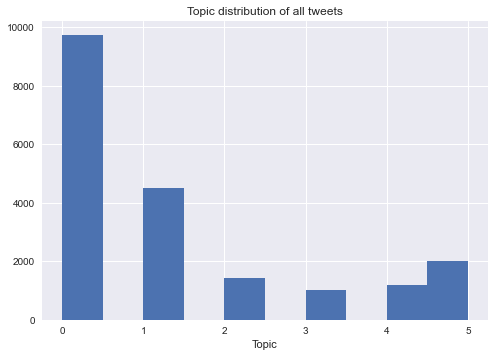

In [31]:
#explicitly get topic distribution (to get total number of tweets per topic)
def get_top_topic(distribution):
    top_topic = 0
    top_prob = 0 
    for topic in distribution:
        if topic[1] > top_prob:
            top_topic = topic[0]
            top_prob = topic[1] 
    return top_topic
#get topic probabilities for all tweets
plt.style.use('seaborn')
full_dic, full_corpus = create_dic_corpus(df['tokenized'])
df['topic distribution'] = df['tokenized'].apply(lambda x: optimal_full.get_document_topics(full_dic.doc2bow(x)))
df['topic'] = df['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df['topic'].hist()
plt.title('Topic distribution of all tweets')
plt.xlabel('Topic')
plt.show()

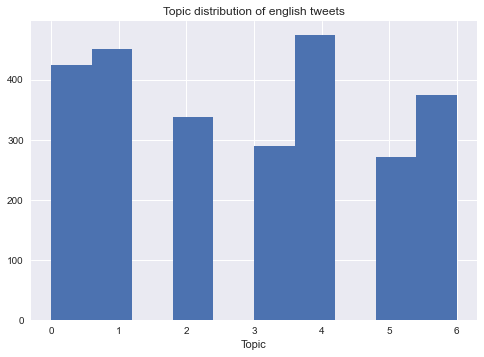

In [32]:
#get topic probabilities for all tweets
en_dic, en_corpus = create_dic_corpus(df_en['tokenized'])
df_en['topic distribution'] = df_en['tokenized'].apply(lambda x: optimal_en.get_document_topics(en_dic.doc2bow(x)))
df_en['topic'] = df_en['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_en['topic'].hist()
plt.title('Topic distribution of english tweets')
plt.xlabel('Topic')
plt.show()

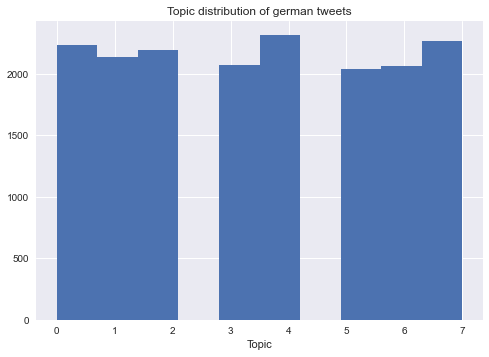

In [33]:
#get topic probabilities for all tweets
ger_dic, ger_corpus = create_dic_corpus(df_ger['tokenized'])
df_ger['topic distribution'] = df_ger['tokenized'].apply(lambda x: optimal_ger.get_document_topics(ger_dic.doc2bow(x)))
df_ger['topic'] = df_ger['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_ger['topic'].hist()
plt.title('Topic distribution of german tweets')
plt.xlabel('Topic')
plt.show()

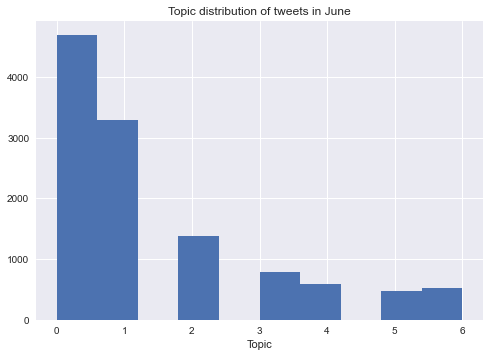

In [34]:
#get topic probabilities for all tweets
june_dic, june_corpus = create_dic_corpus(df_june['tokenized'])
df_june['topic distribution'] = df_june['tokenized'].apply(lambda x: optimal_june.get_document_topics(june_dic.doc2bow(x)))
df_june['topic'] = df_june['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_june['topic'].hist()
plt.title('Topic distribution of tweets in June')
plt.xlabel('Topic')
plt.show()

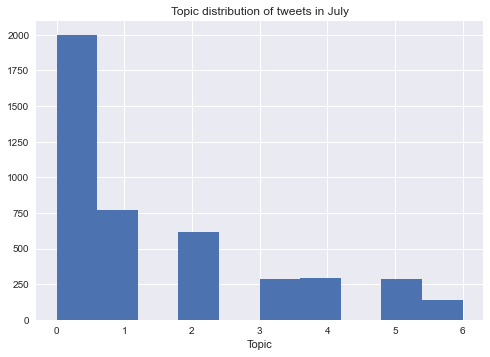

In [35]:
#get topic probabilities for all tweets
july_dic, july_corpus = create_dic_corpus(df_july['tokenized'])
df_july['topic distribution'] = df_july['tokenized'].apply(lambda x: optimal_july.get_document_topics(july_dic.doc2bow(x)))
df_july['topic'] = df_july['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_july['topic'].hist()
plt.title('Topic distribution of tweets in July')
plt.xlabel('Topic')
plt.show()

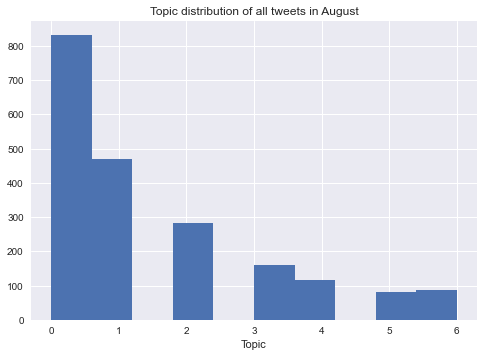

In [36]:
#get topic probabilities for all tweets
august_dic, august_corpus = create_dic_corpus(df_august['tokenized'])
df_august['topic distribution'] = df_august['tokenized'].apply(lambda x: optimal_august.get_document_topics(august_dic.doc2bow(x)))
df_august['topic'] = df_august['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_august['topic'].hist()
plt.title('Topic distribution of all tweets in August')
plt.xlabel('Topic')
plt.show()

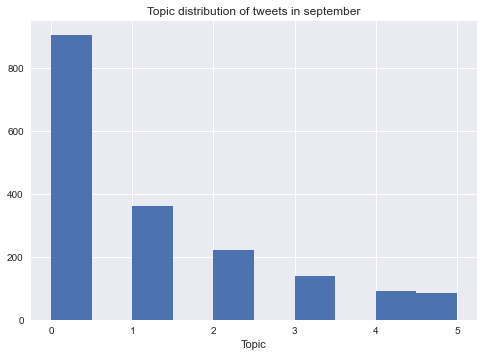

In [37]:
#get topic probabilities for all tweets
september_dic, september_corpus = create_dic_corpus(df_september['tokenized'])
df_september['topic distribution'] = df_september['tokenized'].apply(lambda x: optimal_september.get_document_topics(september_dic.doc2bow(x)))
df_september['topic'] = df_september['topic distribution'].apply(lambda x: get_top_topic(x))
#distribution of topics
df_september['topic'].hist()
plt.title('Topic distribution of tweets in september')
plt.xlabel('Topic')
plt.show()

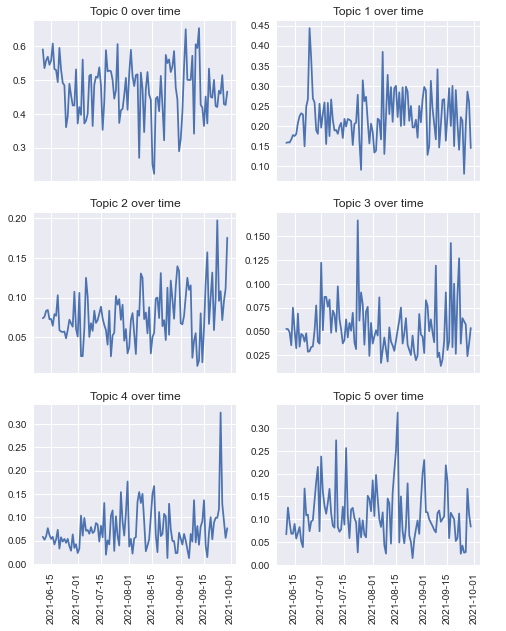

In [52]:
#show the development of tweet frequency of topics over time for the whole set; not particularly insightful for full data
df_topic0 = df.loc[df['topic'] == 0]
df_topic1 = df.loc[df['topic'] == 1]
df_topic2 = df.loc[df['topic'] == 2]
df_topic3 = df.loc[df['topic'] == 3]
df_topic4 = df.loc[df['topic'] == 4]
df_topic5 = df.loc[df['topic'] == 5]
#divide number of tweets of a topic at a day by the total number of topics on that day, to lessen the effect of days with a high tweet frequency
df_freqs = pd.DataFrame(pd.to_datetime(df['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic0 = pd.DataFrame(pd.to_datetime(df_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic0 = df_topic0.merge(df_freqs, on ='index')
df_topic0['count'] = df_topic0['new_date_x']/df_topic0['new_date_y'] 
df_topic1 = pd.DataFrame(pd.to_datetime(df_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic1 = df_topic1.merge(df_freqs, on ='index')
df_topic1['count'] = df_topic1['new_date_x']/df_topic1['new_date_y'] 
df_topic2 = pd.DataFrame(pd.to_datetime(df_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic2 = df_topic2.merge(df_freqs, on ='index')
df_topic2['count'] = df_topic2['new_date_x']/df_topic2['new_date_y'] 
df_topic3 = pd.DataFrame(pd.to_datetime(df_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic3 = df_topic3.merge(df_freqs, on ='index')
df_topic3['count'] = df_topic3['new_date_x']/df_topic3['new_date_y'] 
df_topic4 = pd.DataFrame(pd.to_datetime(df_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic4 = df_topic4.merge(df_freqs, on ='index')
df_topic4['count'] = df_topic4['new_date_x']/df_topic4['new_date_y'] 
df_topic5 = pd.DataFrame(pd.to_datetime(df_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_topic5 = df_topic5.merge(df_freqs, on ='index')
df_topic5['count'] = df_topic5['new_date_x']/df_topic5['new_date_y']
plt.subplot(3, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_topic0['index'], df_topic0['count'])
plt.xticks(color='w')
plt.subplot(3, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_topic1['index'], df_topic1['count'])
plt.xticks(color='w')
plt.subplot(3, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_topic2['index'], df_topic2['count'])
plt.xticks(color='w')
plt.subplot(3, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_topic3['index'], df_topic3['count'])
plt.xticks(color='w')
plt.subplot(3, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_topic4['index'], df_topic4['count'])
plt.xticks(rotation='vertical')
plt.subplot(3, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_topic5['index'], df_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

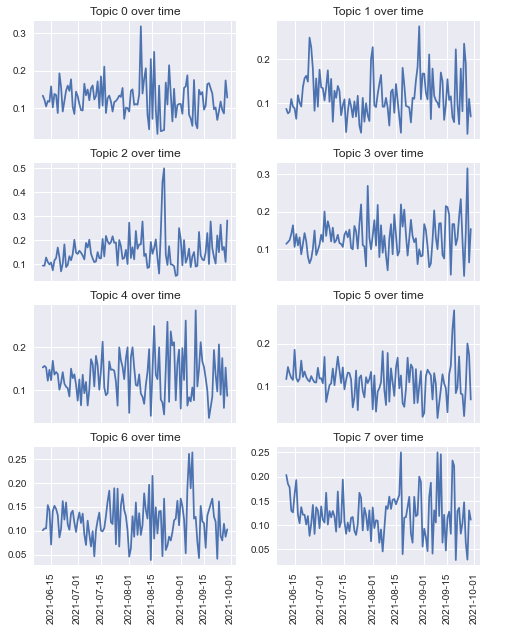

In [53]:
#show the development of tweet frequency of topics over time for the german tweets
df_ger_topic0 = df_ger.loc[df_ger['topic'] == 0]
df_ger_topic1 = df_ger.loc[df_ger['topic'] == 1]
df_ger_topic2 = df_ger.loc[df_ger['topic'] == 2]
df_ger_topic3 = df_ger.loc[df_ger['topic'] == 3]
df_ger_topic4 = df_ger.loc[df_ger['topic'] == 4]
df_ger_topic5 = df_ger.loc[df_ger['topic'] == 5]
df_ger_topic6 = df_ger.loc[df_ger['topic'] == 6]
df_ger_topic7 = df_ger.loc[df_ger['topic'] == 7]
df_ger_freqs = pd.DataFrame(pd.to_datetime(df_ger['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic0 = pd.DataFrame(pd.to_datetime(df_ger_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic0 = df_ger_topic0.merge(df_ger_freqs, on ='index')
df_ger_topic0['count'] = df_ger_topic0['new_date_x']/df_ger_topic0['new_date_y'] 
df_ger_topic1 = pd.DataFrame(pd.to_datetime(df_ger_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic1 = df_ger_topic1.merge(df_ger_freqs, on ='index')
df_ger_topic1['count'] = df_ger_topic1['new_date_x']/df_ger_topic1['new_date_y'] 
df_ger_topic2 = pd.DataFrame(pd.to_datetime(df_ger_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic2 = df_ger_topic2.merge(df_ger_freqs, on ='index')
df_ger_topic2['count'] = df_ger_topic2['new_date_x']/df_ger_topic2['new_date_y'] 
df_ger_topic3 = pd.DataFrame(pd.to_datetime(df_ger_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic3 = df_ger_topic3.merge(df_ger_freqs, on ='index')
df_ger_topic3['count'] = df_ger_topic3['new_date_x']/df_ger_topic3['new_date_y'] 
df_ger_topic4 = pd.DataFrame(pd.to_datetime(df_ger_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic4 = df_ger_topic4.merge(df_ger_freqs, on ='index')
df_ger_topic4['count'] = df_ger_topic4['new_date_x']/df_ger_topic4['new_date_y'] 
df_ger_topic5 = pd.DataFrame(pd.to_datetime(df_ger_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic5 = df_ger_topic5.merge(df_ger_freqs, on ='index')
df_ger_topic5['count'] = df_ger_topic5['new_date_x']/df_ger_topic5['new_date_y']
df_ger_topic6 = pd.DataFrame(pd.to_datetime(df_ger_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic6 = df_ger_topic6.merge(df_ger_freqs, on ='index')
df_ger_topic6['count'] = df_ger_topic6['new_date_x']/df_ger_topic6['new_date_y'] 
df_ger_topic7 = pd.DataFrame(pd.to_datetime(df_ger_topic7['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_ger_topic7 = df_ger_topic7.merge(df_ger_freqs, on ='index')
df_ger_topic7['count'] = df_ger_topic7['new_date_x']/df_ger_topic7['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_ger_topic0['index'], df_ger_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_ger_topic1['index'], df_ger_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_ger_topic2['index'], df_ger_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_ger_topic3['index'], df_ger_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_ger_topic4['index'], df_ger_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_ger_topic5['index'], df_ger_topic5['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_ger_topic6['index'], df_ger_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 8)
plt.title('Topic 7 over time')
plt.plot(df_ger_topic7['index'], df_ger_topic7['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

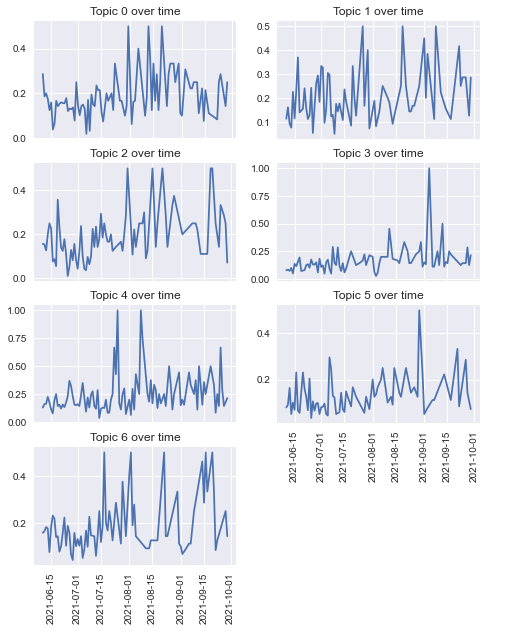

In [54]:
#show the development of tweet frequency of topics over time for the english tweets
df_en_topic0 = df_en.loc[df_en['topic'] == 0]
df_en_topic1 = df_en.loc[df_en['topic'] == 1]
df_en_topic2 = df_en.loc[df_en['topic'] == 2]
df_en_topic3 = df_en.loc[df_en['topic'] == 3]
df_en_topic4 = df_en.loc[df_en['topic'] == 4]
df_en_topic5 = df_en.loc[df_en['topic'] == 5]
df_en_topic6 = df_en.loc[df_en['topic'] == 6]
df_en_freqs = pd.DataFrame(pd.to_datetime(df_en['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic0 = pd.DataFrame(pd.to_datetime(df_en_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic0 = df_en_topic0.merge(df_en_freqs, on ='index')
df_en_topic0['count'] = df_en_topic0['new_date_x']/df_en_topic0['new_date_y'] 
df_en_topic1 = pd.DataFrame(pd.to_datetime(df_en_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic1 = df_en_topic1.merge(df_en_freqs, on ='index')
df_en_topic1['count'] = df_en_topic1['new_date_x']/df_en_topic1['new_date_y'] 
df_en_topic2 = pd.DataFrame(pd.to_datetime(df_en_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic2 = df_en_topic2.merge(df_en_freqs, on ='index')
df_en_topic2['count'] = df_en_topic2['new_date_x']/df_en_topic2['new_date_y'] 
df_en_topic3 = pd.DataFrame(pd.to_datetime(df_en_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic3 = df_en_topic3.merge(df_en_freqs, on ='index')
df_en_topic3['count'] = df_en_topic3['new_date_x']/df_en_topic3['new_date_y'] 
df_en_topic4 = pd.DataFrame(pd.to_datetime(df_en_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic4 = df_en_topic4.merge(df_en_freqs, on ='index')
df_en_topic4['count'] = df_en_topic4['new_date_x']/df_en_topic4['new_date_y'] 
df_en_topic5 = pd.DataFrame(pd.to_datetime(df_en_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic5 = df_en_topic5.merge(df_en_freqs, on ='index')
df_en_topic5['count'] = df_en_topic5['new_date_x']/df_en_topic5['new_date_y']
df_en_topic6 = pd.DataFrame(pd.to_datetime(df_en_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_en_topic6 = df_en_topic6.merge(df_en_freqs, on ='index')
df_en_topic6['count'] = df_en_topic6['new_date_x']/df_en_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_en_topic0['index'], df_en_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_en_topic1['index'], df_en_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_en_topic2['index'], df_en_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_en_topic3['index'], df_en_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_en_topic4['index'], df_en_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_en_topic5['index'], df_en_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_en_topic6['index'], df_en_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

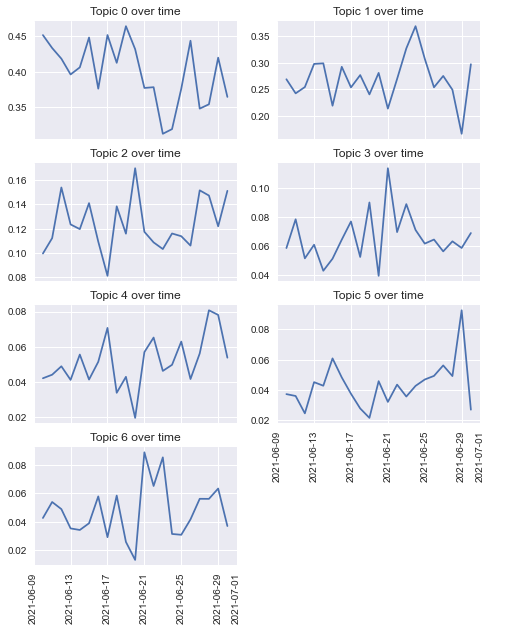

In [55]:
#show the development of tweet frequency of topics over time for the tweets in june
df_june_topic0 = df_june.loc[df_june['topic'] == 0]
df_june_topic1 = df_june.loc[df_june['topic'] == 1]
df_june_topic2 = df_june.loc[df_june['topic'] == 2]
df_june_topic3 = df_june.loc[df_june['topic'] == 3]
df_june_topic4 = df_june.loc[df_june['topic'] == 4]
df_june_topic5 = df_june.loc[df_june['topic'] == 5]
df_june_topic6 = df_june.loc[df_june['topic'] == 6]
df_june_freqs = pd.DataFrame(pd.to_datetime(df_june['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic0 = pd.DataFrame(pd.to_datetime(df_june_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic0 = df_june_topic0.merge(df_june_freqs, on ='index')
df_june_topic0['count'] = df_june_topic0['new_date_x']/df_june_topic0['new_date_y'] 
df_june_topic1 = pd.DataFrame(pd.to_datetime(df_june_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic1 = df_june_topic1.merge(df_june_freqs, on ='index')
df_june_topic1['count'] = df_june_topic1['new_date_x']/df_june_topic1['new_date_y'] 
df_june_topic2 = pd.DataFrame(pd.to_datetime(df_june_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic2 = df_june_topic2.merge(df_june_freqs, on ='index')
df_june_topic2['count'] = df_june_topic2['new_date_x']/df_june_topic2['new_date_y'] 
df_june_topic3 = pd.DataFrame(pd.to_datetime(df_june_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic3 = df_june_topic3.merge(df_june_freqs, on ='index')
df_june_topic3['count'] = df_june_topic3['new_date_x']/df_june_topic3['new_date_y'] 
df_june_topic4 = pd.DataFrame(pd.to_datetime(df_june_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic4 = df_june_topic4.merge(df_june_freqs, on ='index')
df_june_topic4['count'] = df_june_topic4['new_date_x']/df_june_topic4['new_date_y'] 
df_june_topic5 = pd.DataFrame(pd.to_datetime(df_june_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic5 = df_june_topic5.merge(df_june_freqs, on ='index')
df_june_topic5['count'] = df_june_topic5['new_date_x']/df_june_topic5['new_date_y']
df_june_topic6 = pd.DataFrame(pd.to_datetime(df_june_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_june_topic6 = df_june_topic6.merge(df_june_freqs, on ='index')
df_june_topic6['count'] = df_june_topic6['new_date_x']/df_june_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_june_topic0['index'], df_june_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_june_topic1['index'], df_june_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_june_topic2['index'], df_june_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_june_topic3['index'], df_june_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_june_topic4['index'], df_june_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_june_topic5['index'], df_june_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_june_topic6['index'], df_june_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

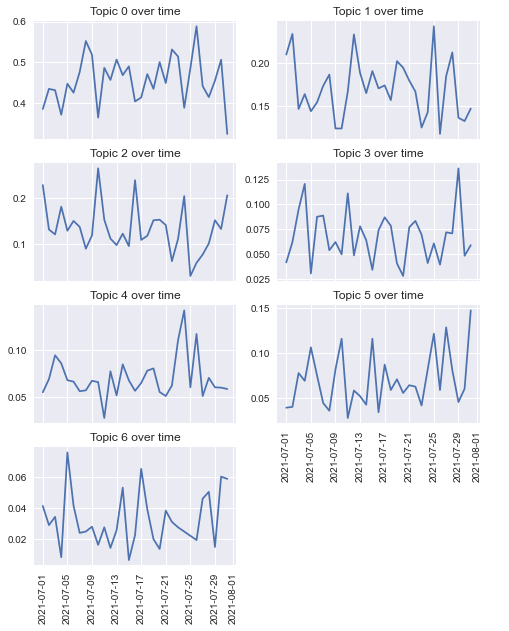

In [56]:
#show the development of tweet frequency of topics over time for the tweets in july
df_july_topic0 = df_july.loc[df_july['topic'] == 0]
df_july_topic1 = df_july.loc[df_july['topic'] == 1]
df_july_topic2 = df_july.loc[df_july['topic'] == 2]
df_july_topic3 = df_july.loc[df_july['topic'] == 3]
df_july_topic4 = df_july.loc[df_july['topic'] == 4]
df_july_topic5 = df_july.loc[df_july['topic'] == 5]
df_july_topic6 = df_july.loc[df_july['topic'] == 6]
df_july_freqs = pd.DataFrame(pd.to_datetime(df_july['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic0 = pd.DataFrame(pd.to_datetime(df_july_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic0 = df_july_topic0.merge(df_july_freqs, on ='index')
df_july_topic0['count'] = df_july_topic0['new_date_x']/df_july_topic0['new_date_y'] 
df_july_topic1 = pd.DataFrame(pd.to_datetime(df_july_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic1 = df_july_topic1.merge(df_july_freqs, on ='index')
df_july_topic1['count'] = df_july_topic1['new_date_x']/df_july_topic1['new_date_y'] 
df_july_topic2 = pd.DataFrame(pd.to_datetime(df_july_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic2 = df_july_topic2.merge(df_july_freqs, on ='index')
df_july_topic2['count'] = df_july_topic2['new_date_x']/df_july_topic2['new_date_y'] 
df_july_topic3 = pd.DataFrame(pd.to_datetime(df_july_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic3 = df_july_topic3.merge(df_july_freqs, on ='index')
df_july_topic3['count'] = df_july_topic3['new_date_x']/df_july_topic3['new_date_y'] 
df_july_topic4 = pd.DataFrame(pd.to_datetime(df_july_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic4 = df_july_topic4.merge(df_july_freqs, on ='index')
df_july_topic4['count'] = df_july_topic4['new_date_x']/df_july_topic4['new_date_y'] 
df_july_topic5 = pd.DataFrame(pd.to_datetime(df_july_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic5 = df_july_topic5.merge(df_july_freqs, on ='index')
df_july_topic5['count'] = df_july_topic5['new_date_x']/df_july_topic5['new_date_y']
df_july_topic6 = pd.DataFrame(pd.to_datetime(df_july_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_july_topic6 = df_july_topic6.merge(df_july_freqs, on ='index')
df_july_topic6['count'] = df_july_topic6['new_date_x']/df_july_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_july_topic0['index'], df_july_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_july_topic1['index'], df_july_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_july_topic2['index'], df_july_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_july_topic3['index'], df_july_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_july_topic4['index'], df_july_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_july_topic5['index'], df_july_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_july_topic6['index'], df_july_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

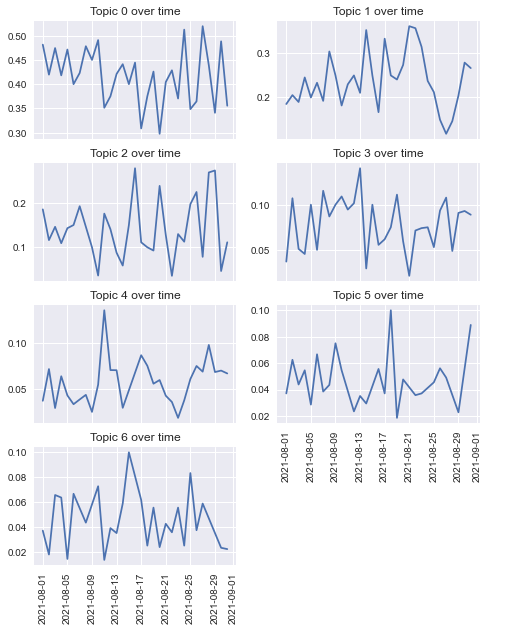

In [57]:
#show the development of tweet frequency of topics over time for the tweets in august
df_august_topic0 = df_august.loc[df_august['topic'] == 0]
df_august_topic1 = df_august.loc[df_august['topic'] == 1]
df_august_topic2 = df_august.loc[df_august['topic'] == 2]
df_august_topic3 = df_august.loc[df_august['topic'] == 3]
df_august_topic4 = df_august.loc[df_august['topic'] == 4]
df_august_topic5 = df_august.loc[df_august['topic'] == 5]
df_august_topic6 = df_august.loc[df_august['topic'] == 6]
df_august_freqs = pd.DataFrame(pd.to_datetime(df_august['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic0 = pd.DataFrame(pd.to_datetime(df_august_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic0 = df_august_topic0.merge(df_august_freqs, on ='index')
df_august_topic0['count'] = df_august_topic0['new_date_x']/df_august_topic0['new_date_y'] 
df_august_topic1 = pd.DataFrame(pd.to_datetime(df_august_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic1 = df_august_topic1.merge(df_august_freqs, on ='index')
df_august_topic1['count'] = df_august_topic1['new_date_x']/df_august_topic1['new_date_y'] 
df_august_topic2 = pd.DataFrame(pd.to_datetime(df_august_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic2 = df_august_topic2.merge(df_august_freqs, on ='index')
df_august_topic2['count'] = df_august_topic2['new_date_x']/df_august_topic2['new_date_y'] 
df_august_topic3 = pd.DataFrame(pd.to_datetime(df_august_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic3 = df_august_topic3.merge(df_august_freqs, on ='index')
df_august_topic3['count'] = df_august_topic3['new_date_x']/df_august_topic3['new_date_y'] 
df_august_topic4 = pd.DataFrame(pd.to_datetime(df_august_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic4 = df_august_topic4.merge(df_august_freqs, on ='index')
df_august_topic4['count'] = df_august_topic4['new_date_x']/df_august_topic4['new_date_y'] 
df_august_topic5 = pd.DataFrame(pd.to_datetime(df_august_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic5 = df_august_topic5.merge(df_august_freqs, on ='index')
df_august_topic5['count'] = df_august_topic5['new_date_x']/df_august_topic5['new_date_y']
df_august_topic6 = pd.DataFrame(pd.to_datetime(df_august_topic6['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_august_topic6 = df_august_topic6.merge(df_august_freqs, on ='index')
df_august_topic6['count'] = df_august_topic6['new_date_x']/df_august_topic6['new_date_y'] 
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_august_topic0['index'], df_august_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_august_topic1['index'], df_august_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_august_topic2['index'], df_august_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_august_topic3['index'], df_august_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_august_topic4['index'], df_august_topic4['count'])
plt.xticks(rotation='vertical')
plt.xticks(color='w')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_august_topic5['index'], df_august_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 7)
plt.title('Topic 6 over time')
plt.plot(df_august_topic6['index'], df_august_topic6['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

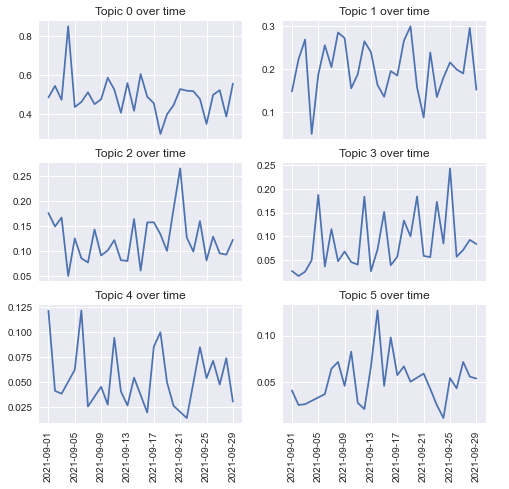

In [58]:
#show the development of tweet frequency of topics over time for the tweets in august
df_september_topic0 = df_september.loc[df_september['topic'] == 0]
df_september_topic1 = df_september.loc[df_september['topic'] == 1]
df_september_topic2 = df_september.loc[df_september['topic'] == 2]
df_september_topic3 = df_september.loc[df_september['topic'] == 3]
df_september_topic4 = df_september.loc[df_september['topic'] == 4]
df_september_topic5 = df_september.loc[df_september['topic'] == 5]
df_september_freqs = pd.DataFrame(pd.to_datetime(df_september['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic0 = pd.DataFrame(pd.to_datetime(df_september_topic0['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic0 = df_september_topic0.merge(df_september_freqs, on ='index')
df_september_topic0['count'] = df_september_topic0['new_date_x']/df_september_topic0['new_date_y'] 
df_september_topic1 = pd.DataFrame(pd.to_datetime(df_september_topic1['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic1 = df_september_topic1.merge(df_september_freqs, on ='index')
df_september_topic1['count'] = df_september_topic1['new_date_x']/df_september_topic1['new_date_y'] 
df_september_topic2 = pd.DataFrame(pd.to_datetime(df_september_topic2['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic2 = df_september_topic2.merge(df_september_freqs, on ='index')
df_september_topic2['count'] = df_september_topic2['new_date_x']/df_september_topic2['new_date_y'] 
df_september_topic3 = pd.DataFrame(pd.to_datetime(df_september_topic3['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic3 = df_september_topic3.merge(df_september_freqs, on ='index')
df_september_topic3['count'] = df_september_topic3['new_date_x']/df_september_topic3['new_date_y'] 
df_september_topic4 = pd.DataFrame(pd.to_datetime(df_september_topic4['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic4 = df_september_topic4.merge(df_september_freqs, on ='index')
df_september_topic4['count'] = df_september_topic4['new_date_x']/df_september_topic4['new_date_y'] 
df_september_topic5 = pd.DataFrame(pd.to_datetime(df_september_topic5['new_date']).dt.date.value_counts()).reset_index().sort_values('index')
df_september_topic5 = df_september_topic5.merge(df_september_freqs, on ='index')
df_september_topic5['count'] = df_september_topic5['new_date_x']/df_september_topic5['new_date_y']
plt.subplot(4, 2, 1)
plt.title('Topic 0 over time')
plt.plot(df_september_topic0['index'], df_september_topic0['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 2)
plt.title('Topic 1 over time')
plt.plot(df_september_topic1['index'], df_september_topic1['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 3)
plt.title('Topic 2 over time')
plt.plot(df_september_topic2['index'], df_september_topic2['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 4)
plt.title('Topic 3 over time')
plt.plot(df_september_topic3['index'], df_september_topic3['count'])
plt.xticks(color='w')
plt.subplot(4, 2, 5)
plt.title('Topic 4 over time')
plt.plot(df_september_topic4['index'], df_september_topic4['count'])
plt.xticks(rotation='vertical')
plt.subplot(4, 2, 6)
plt.title('Topic 5 over time')
plt.plot(df_september_topic5['index'], df_september_topic5['count'])
plt.xticks(rotation='vertical')
plt.subplots_adjust(top=1.5)
plt.show()

## Proportion of topics within user groups

In [59]:
#identify different user groups for whole data set
df_pos = df.loc[df['user.group'] == "Postdoc"]
df_prom = df.loc[df['user.group'] == "Promovierende"]
df_stu = df.loc[df['user.group'] == "Student"]
df_prof = df.loc[df['user.group'] == "Prof"]
df_med = df.loc[df['user.group'] == "Media"]
df_pol = df.loc[df['user.group'] == "Political rep"]
df_uni = df.loc[df['user.group'] == "Union rep"]
df_ins = df.loc[df['user.group'] == "Institution"]
df_bot = df.loc[df['user.group'] == "Bot"]
df_jun = df.loc[df['user.group'] == "Jun. prof"]
df_tea = df.loc[df['user.group'] == "Teacher"]
df_medic = df.loc[df['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.469306
1  0.212859
5  0.139847
2  0.065565
4  0.059753
3  0.052670
      topic
0  0.474780
1  0.213771
5  0.148919
2  0.070456
4  0.051241
3  0.040833
      topic
0  0.481328
1  0.278008
5  0.103734
4  0.058091
2  0.053942
3  0.024896
      topic
0  0.466397
1  0.236437
5  0.139271
2  0.067206
3  0.046964
4  0.043725
      topic
0  0.473815
1  0.286783
2  0.094763
4  0.069825
3  0.059850
5  0.014963
      topic
0  0.460993
1  0.382979
2  0.070922
3  0.035461
4  0.035461
5  0.014184
      topic
1  0.358974
0  0.243590
4  0.147436
2  0.099359
3  0.086538
5  0.064103
      topic
0  0.362264
1  0.362264
2  0.090566
4  0.067925
5  0.064151
3  0.052830
      topic
0  0.433333
1  0.416667
2  0.066667
4  0.050000
3  0.033333
      topic
0  0.544444
1  0.188889
5  0.122222
2  0.088889
4  0.033333
3  0.022222
      topic
0  0.714286
1  0.178571
5  0.035714
2  0.035714
3  0.035714
   topic
1    1.0


In [60]:
#identify different user groups for german data set
df_pos = df_ger.loc[df_ger['user.group'] == "Postdoc"]
df_prom = df_ger.loc[df_ger['user.group'] == "Promovierende"]
df_stu = df_ger.loc[df_ger['user.group'] == "Student"]
df_prof = df_ger.loc[df_ger['user.group'] == "Prof"]
df_med = df_ger.loc[df_ger['user.group'] == "Media"]
df_pol = df_ger.loc[df_ger['user.group'] == "Political rep"]
df_uni = df_ger.loc[df_ger['user.group'] == "Union rep"]
df_ins = df_ger.loc[df_ger['user.group'] == "Institution"]
df_bot = df_ger.loc[df_ger['user.group'] == "Bot"]
df_jun = df_ger.loc[df_ger['user.group'] == "Jun. prof"]
df_tea = df_ger.loc[df_ger['user.group'] == "Teacher"]
df_medic = df_ger.loc[df_ger['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
4  0.136756
7  0.130339
2  0.126798
1  0.124806
6  0.124364
0  0.122151
3  0.120823
5  0.113963
      topic
4  0.138298
0  0.132495
7  0.131528
2  0.129594
1  0.119923
3  0.117988
5  0.116054
6  0.114120
      topic
3  0.174528
5  0.146226
7  0.127358
0  0.122642
1  0.113208
6  0.108491
4  0.103774
2  0.103774
      topic
1  0.156436
2  0.138614
0  0.130693
4  0.124752
5  0.123762
7  0.119802
3  0.109901
6  0.096040
      topic
7  0.164524
0  0.159383
6  0.149100
1  0.141388
5  0.100257
2  0.100257
3  0.092545
4  0.092545
      topic
1  0.177305
0  0.141844
6  0.141844
3  0.134752
5  0.120567
4  0.099291
7  0.092199
2  0.092199
      topic
3  0.334448
2  0.167224
1  0.110368
6  0.107023
4  0.080268
7  0.073579
5  0.066890
0  0.060201
      topic
2  0.191057
1  0.146341
0  0.134146
6  0.126016
3  0.121951
7  0.101626
5  0.089431
4  0.089431
      topic
7  0.196429
2  0.196429
6  0.196429
1  0.178571
4  0.089286
3  0.053571
5  0.053571
0  0.035714
      topic
4  0.160494
7  0

In [61]:
#identify different user groups for english data set
df_pos = df_en.loc[df_en['user.group'] == "Postdoc"]
df_prom = df_en.loc[df_en['user.group'] == "Promovierende"]
df_stu = df_en.loc[df_en['user.group'] == "Student"]
df_prof = df_en.loc[df_en['user.group'] == "Prof"]
df_med = df_en.loc[df_en['user.group'] == "Media"]
df_pol = df_en.loc[df_en['user.group'] == "Political rep"]
df_uni = df_en.loc[df_en['user.group'] == "Union rep"]
df_ins = df_en.loc[df_en['user.group'] == "Institution"]
df_bot = df_en.loc[df_en['user.group'] == "Bot"]
df_jun = df_en.loc[df_en['user.group'] == "Jun. prof"]
df_tea = df_en.loc[df_en['user.group'] == "Teacher"]
df_medic = df_en.loc[df_en['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
1  0.242148
4  0.170213
2  0.130699
6  0.129686
0  0.127660
3  0.121581
5  0.078014
      topic
6  0.209302
4  0.181395
0  0.162791
1  0.158140
3  0.102326
2  0.102326
5  0.083721
      topic
0  0.241379
1  0.172414
6  0.137931
2  0.137931
4  0.137931
3  0.103448
5  0.068966
      topic
0  0.191111
4  0.186667
6  0.168889
2  0.142222
1  0.133333
5  0.106667
3  0.071111
      topic
0  0.416667
1  0.250000
2  0.083333
4  0.083333
5  0.083333
6  0.083333
Empty DataFrame
Columns: [topic]
Index: []
      topic
1  0.461538
0  0.230769
6  0.076923
2  0.076923
4  0.076923
5  0.076923
      topic
4  0.421053
6  0.210526
1  0.105263
2  0.105263
5  0.105263
0  0.052632
   topic
3    0.5
6    0.5
      topic
1  0.333333
5  0.222222
4  0.222222
6  0.111111
0  0.111111
      topic
0  0.666667
4  0.333333
Empty DataFrame
Columns: [topic]
Index: []


In [62]:
#identify different user groups for June
df_pos = df_june.loc[df_june['user.group'] == "Postdoc"]
df_prom = df_june.loc[df_june['user.group'] == "Promovierende"]
df_stu = df_june.loc[df_june['user.group'] == "Student"]
df_prof = df_june.loc[df_june['user.group'] == "Prof"]
df_med = df_june.loc[df_june['user.group'] == "Media"]
df_pol = df_june.loc[df_june['user.group'] == "Political rep"]
df_uni = df_june.loc[df_june['user.group'] == "Union rep"]
df_ins = df_june.loc[df_june['user.group'] == "Institution"]
df_bot = df_june.loc[df_june['user.group'] == "Bot"]
df_jun = df_june.loc[df_june['user.group'] == "Jun. prof"]
df_tea = df_june.loc[df_june['user.group'] == "Teacher"]
df_medic = df_june.loc[df_june['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.405488
1  0.254743
2  0.126694
3  0.067073
4  0.060976
6  0.045393
5  0.039634
      topic
0  0.373950
1  0.287115
2  0.124650
6  0.074230
3  0.061625
4  0.046218
5  0.032213
      topic
0  0.378378
1  0.351351
2  0.121622
6  0.047297
3  0.040541
5  0.033784
4  0.027027
      topic
0  0.360256
1  0.269231
2  0.129487
3  0.093590
6  0.062821
4  0.048718
5  0.035897
      topic
1  0.360324
0  0.344130
2  0.137652
3  0.056680
4  0.048583
5  0.032389
6  0.020243
      topic
1  0.383178
0  0.336449
3  0.102804
2  0.102804
4  0.046729
5  0.028037
      topic
1  0.440367
0  0.293578
2  0.137615
5  0.055046
3  0.036697
6  0.018349
4  0.018349
      topic
0  0.293103
1  0.284483
2  0.206897
4  0.077586
5  0.060345
3  0.051724
6  0.025862
      topic
1  0.423077
0  0.346154
2  0.115385
4  0.076923
3  0.038462
      topic
0  0.350877
1  0.245614
2  0.210526
5  0.087719
4  0.035088
3  0.035088
6  0.035088
      topic
0  0.458333
1  0.208333
3  0.125000
2  0.083333
6  0.083333
4  0

In [63]:
#identify different user groups for July
df_pos = df_july.loc[df_july['user.group'] == "Postdoc"]
df_prom = df_july.loc[df_july['user.group'] == "Promovierende"]
df_stu = df_july.loc[df_july['user.group'] == "Student"]
df_prof = df_july.loc[df_july['user.group'] == "Prof"]
df_med = df_july.loc[df_july['user.group'] == "Media"]
df_pol = df_july.loc[df_july['user.group'] == "Political rep"]
df_uni = df_july.loc[df_july['user.group'] == "Union rep"]
df_ins = df_july.loc[df_july['user.group'] == "Institution"]
df_bot = df_july.loc[df_july['user.group'] == "Bot"]
df_jun = df_july.loc[df_july['user.group'] == "Jun. prof"]
df_tea = df_july.loc[df_july['user.group'] == "Teacher"]
df_medic = df_july.loc[df_july['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.416312
2  0.200000
1  0.167376
3  0.067376
5  0.062411
4  0.060284
6  0.026241
      topic
0  0.433824
1  0.165441
2  0.150735
3  0.084559
5  0.077206
4  0.051471
6  0.036765
      topic
0  0.508475
1  0.186441
2  0.101695
5  0.084746
4  0.067797
6  0.050847
      topic
0  0.442308
1  0.182692
2  0.131410
4  0.105769
5  0.060897
3  0.054487
6  0.022436
      topic
0  0.584416
4  0.116883
1  0.116883
2  0.090909
3  0.051948
6  0.025974
5  0.012987
      topic
0  0.571429
6  0.142857
5  0.142857
1  0.071429
2  0.071429
      topic
0  0.541667
5  0.194444
1  0.180556
6  0.027778
2  0.027778
3  0.013889
4  0.013889
      topic
0  0.533333
1  0.200000
2  0.080000
5  0.080000
3  0.080000
4  0.026667
   topic
0    1.0
    topic
1  0.3125
0  0.2500
4  0.1875
2  0.1875
5  0.0625
   topic
4   0.25
1   0.25
0   0.25
3   0.25
Empty DataFrame
Columns: [topic]
Index: []


In [64]:
#identify different user groups for August
df_pos = df_august.loc[df_august['user.group'] == "Postdoc"]
df_prom = df_august.loc[df_august['user.group'] == "Promovierende"]
df_stu = df_august.loc[df_august['user.group'] == "Student"]
df_prof = df_august.loc[df_august['user.group'] == "Prof"]
df_med = df_august.loc[df_august['user.group'] == "Media"]
df_pol = df_august.loc[df_august['user.group'] == "Political rep"]
df_uni = df_august.loc[df_august['user.group'] == "Union rep"]
df_ins = df_august.loc[df_august['user.group'] == "Institution"]
df_bot = df_august.loc[df_august['user.group'] == "Bot"]
df_jun = df_august.loc[df_august['user.group'] == "Jun. prof"]
df_tea = df_august.loc[df_august['user.group'] == "Teacher"]
df_medic = df_august.loc[df_august['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_bot_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.426494
1  0.189015
2  0.168013
3  0.080775
4  0.051696
6  0.043619
5  0.040388
      topic
0  0.402878
1  0.244604
2  0.129496
3  0.107914
6  0.057554
4  0.043165
5  0.014388
      topic
0  0.500000
1  0.357143
3  0.071429
2  0.071429
      topic
0  0.380435
1  0.282609
2  0.130435
3  0.076087
6  0.065217
4  0.032609
5  0.032609
      topic
0  0.509434
2  0.169811
1  0.113208
3  0.113208
6  0.037736
4  0.037736
5  0.018868
      topic
0  0.363636
2  0.272727
4  0.181818
6  0.090909
1  0.090909
      topic
0  0.267857
1  0.250000
4  0.178571
2  0.125000
3  0.107143
6  0.053571
5  0.017857
      topic
0  0.423077
1  0.307692
2  0.076923
3  0.076923
6  0.076923
4  0.038462
      topic
1  0.333333
0  0.300000
2  0.133333
3  0.100000
5  0.066667
6  0.033333
4  0.033333
      topic
0  0.500000
1  0.428571
3  0.071429
Empty DataFrame
Columns: [topic]
Index: []
Empty DataFrame
Columns: [topic]
Index: []


In [65]:
#identify different user groups for September
df_pos = df_september.loc[df_september['user.group'] == "Postdoc"]
df_prom = df_september.loc[df_september['user.group'] == "Promovierende"]
df_stu = df_september.loc[df_september['user.group'] == "Student"]
df_prof = df_september.loc[df_september['user.group'] == "Prof"]
df_med = df_september.loc[df_september['user.group'] == "Media"]
df_pol = df_september.loc[df_september['user.group'] == "Political rep"]
df_uni = df_september.loc[df_september['user.group'] == "Union rep"]
df_ins = df_september.loc[df_september['user.group'] == "Institution"]
df_bot = df_september.loc[df_september['user.group'] == "Bot"]
df_jun = df_september.loc[df_september['user.group'] == "Jun. prof"]
df_tea = df_september.loc[df_september['user.group'] == "Teacher"]
df_medic = df_september.loc[df_september['user.group'] == "Medical doctor"]
#get the tweets per topic and divide it by the whole amount of tweets for that group to get the proportions
df_pos_count = pd.DataFrame(df_pos['topic'].value_counts())
df_pos_count['topic'] = df_pos_count['topic']/len(df_pos) 
df_prom_count = pd.DataFrame(df_prom['topic'].value_counts())
df_prom_count['topic'] = df_prom_count['topic']/len(df_prom) 
df_stu_count = pd.DataFrame(df_stu['topic'].value_counts())
df_stu_count['topic'] = df_stu_count['topic']/len(df_stu) 
df_prof_count = pd.DataFrame(df_prof['topic'].value_counts())
df_prof_count['topic'] = df_prof_count['topic']/len(df_prof) 
df_med_count = pd.DataFrame(df_med['topic'].value_counts())
df_med_count['topic'] = df_med_count['topic']/len(df_med) 
df_pol_count = pd.DataFrame(df_pol['topic'].value_counts())
df_pol_count['topic'] = df_pol_count['topic']/len(df_pol) 
df_uni_count = pd.DataFrame(df_uni['topic'].value_counts())
df_uni_count['topic'] = df_uni_count['topic']/len(df_uni) 
df_ins_count = pd.DataFrame(df_ins['topic'].value_counts())
df_ins_count['topic'] = df_ins_count['topic']/len(df_ins) 
df_bot_count = pd.DataFrame(df_bot['topic'].value_counts())
df_bot_count['topic'] = df_bot_count['topic']/len(df_bot) 
df_jun_count = pd.DataFrame(df_jun['topic'].value_counts())
df_jun_count['topic'] = df_jun_count['topic']/len(df_jun) 
df_tea_count = pd.DataFrame(df_tea['topic'].value_counts())
df_tea_count['topic'] = df_tea_count['topic']/len(df_tea) 
df_medic_count = pd.DataFrame(df_medic['topic'].value_counts())
df_medic_count['topic'] = df_medic_count['topic']/len(df_medic)
print(df_pos_count)
print(df_prom_count)
print(df_stu_count)
print(df_prof_count)
print(df_med_count)
print(df_pol_count)
print(df_uni_count)
print(df_ins_count)
print(df_jun_count)
print(df_tea_count)
print(df_medic_count)

      topic
0  0.533333
1  0.196190
2  0.114286
3  0.062857
4  0.049524
5  0.043810
      topic
0  0.467742
1  0.266129
2  0.120968
3  0.056452
5  0.048387
4  0.040323
   topic
0   0.40
1   0.25
2   0.20
5   0.10
3   0.05
      topic
0  0.549020
1  0.137255
4  0.117647
2  0.078431
3  0.078431
5  0.039216
      topic
0  0.333333
1  0.208333
4  0.125000
5  0.125000
3  0.125000
2  0.083333
      topic
0  0.444444
5  0.222222
2  0.222222
1  0.111111
      topic
1  0.320000
0  0.266667
2  0.200000
4  0.093333
3  0.080000
5  0.040000
      topic
0  0.625000
1  0.125000
2  0.104167
3  0.062500
4  0.062500
5  0.020833
      topic
0  0.666667
2  0.333333
Empty DataFrame
Columns: [topic]
Index: []
Empty DataFrame
Columns: [topic]
Index: []


In [69]:
print("Topics for the whole model")
print("------ Topic 0: Temporary contracts after promotion ------")
print("jahren jahre stellen immer @anjakarliczek warum promotion system einfach stelle\n")

print("------ Topic 1: Discussion in the German Bundestag ------")
print("#hannaimbundestag @anjakarliczek heute arbeitsbedingungen immer thema hochschulen letzten debatte unis\n")

print("------ Topic 2: WissZeitVG and research in Germany------")
print("forschung lehre system deutschland gerade @gew_bund wisszeitvg #wissenschaft hochschulen problem\n")

print("------ Topic 3: Labour Union GEW ------")
print("system #hannabeidergew stelle @gew_bund forschung tweets @mahaelhissy #95vswisszeitvg #acertaindegreeofflexibility macht\n")

print("------ Topic 4:  General topic about research in Germany(similar to topic 2)------")
print("deutschland forschung #ichbinreyhan jahre lehre bitte unis arbeit @gew_bund müssen\n")

print("------ Topic 5: English topic about temporary contracts and working conditions ------")
print("system research work years contracts working many conditions researchers time")

Topics for the whole model
------ Topic 0: Temporary contracts after promotion ------
jahren jahre stellen immer @anjakarliczek warum promotion system einfach stelle

------ Topic 1: Discussion in the German Bundestag ------
#hannaimbundestag @anjakarliczek heute arbeitsbedingungen immer thema hochschulen letzten debatte unis

------ Topic 2: WissZeitVG and research in Germany------
forschung lehre system deutschland gerade @gew_bund wisszeitvg #wissenschaft hochschulen problem

------ Topic 3: Labour Union GEW ------
system #hannabeidergew stelle @gew_bund forschung tweets @mahaelhissy #95vswisszeitvg #acertaindegreeofflexibility macht

------ Topic 4:  General topic about research in Germany(similar to topic 2)------
deutschland forschung #ichbinreyhan jahre lehre bitte unis arbeit @gew_bund müssen

------ Topic 5: English topic about temporary contracts and working conditions ------
system research work years contracts working many conditions researchers time
